<a href="https://colab.research.google.com/github/isaiasgj0002/ejerciciosIA/blob/main/Algoritmos%20Python/tareas/TresEnRayaRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Juego de Tres en raya programado en python usando aprendizaje por refuerzo(Rl)**
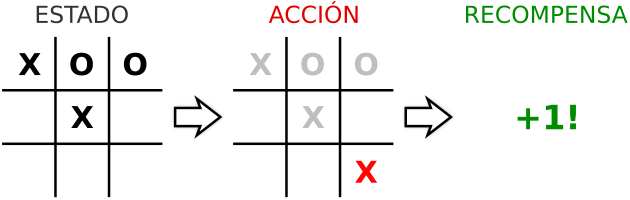

Este algoritmo esta entrenado para que pueda jugar al tres en raya, si gana recibe una recompenza.

El aprendizaje por refuerzo consiste en determinar que acciones debe escoger un agente de software en un entorno dado con el fin de maximizar alguna noción de recompensa. En este caso en entorno sería el tablero de juego donde la acción es que jugada realizara el pc para ganar o bloquear al jugador humano, también existe un estado que es básicamente como se encuentra el tablero en un determinado momento. También existen las políticas o reglas que se almacenan y determinaran al modelo como actuar en cada estado, finalmente si el algoritmo logra derrotar al jugador humano se le otorga la recompensa que sería un puntaje que aumenta de uno en uno.

**Estudiante: Isaias Guzmán Jordán <br>
Semestre: 4 <br>
Curso: Algoritmia para la Inteligencia Artificial**

In [ ]:
import numpy as np
import pickle

In [ ]:
tablero_filas = 3
tablero_columnas = 3

In [ ]:
class Estado:
    def __init__(self, p1, p2):
        self.tablero = np.zeros((tablero_filas, tablero_columnas))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.tableroHash = None
        self.simboloJugador = 1
    
    def getHash(self):
        self.tableroHash = str(self.tablero.reshape(tablero_columnas*tablero_filas))
        return self.tableroHash
    
    def ganador(self):
        for i in range(tablero_filas):
            if sum(self.tablero[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.tablero[i, :]) == -3:
                self.isEnd = True
                return -1
        for i in range(tablero_columnas):
            if sum(self.tablero[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.tablero[:, i]) == -3:
                self.isEnd = True
                return -1
        diag_sum1 = sum([self.tablero[i, i] for i in range(tablero_columnas)])
        diag_sum2 = sum([self.tablero[i, tablero_columnas-i-1] for i in range(tablero_columnas)])
        diag_sum = max(diag_sum1, diag_sum2)
        if diag_sum == 3:
            self.isEnd = True
            return 1
        if diag_sum == -3:
            self.isEnd = True
            return -1
        if len(self.posicionesdisponibles()) == 0:
            self.isEnd = True
            return 0
        self.isEnd = False
        return None
    
    def posicionesdisponibles(self):
        posiciones = []
        for i in range(tablero_filas):
            for j in range(tablero_columnas):
                if self.tablero[i, j] == 0:
                    posiciones.append((i, j))
        return posiciones
    
    def updateEstado(self, position):
        self.tablero[position] = self.simboloJugador
        self.simboloJugador = -1 if self.simboloJugador == 1 else 1
    
    def darRecompensa(self):
        result = self.ganador()
        if result == 1:
            self.p1.otorgaRecompensa(1)
            self.p2.otorgaRecompensa(0)
        elif result == -1:
            self.p1.otorgaRecompensa(0)
            self.p2.otorgaRecompensa(1)
        else:
            self.p1.otorgaRecompensa(0.1)
            self.p2.otorgaRecompensa(0.5)
    def reiniciar(self):
        self.tablero = np.zeros((tablero_filas, tablero_columnas))
        self.tableroHash = None
        self.isEnd = False
        self.simboloJugador = 1
    
    def jugar(self, rounds=100):
        for i in range(rounds):
            if i%1000 == 0:
                print("Rounds {}".format(i))
            while not self.isEnd:
                posiciones = self.posicionesdisponibles()
                p1_accion = self.p1.elegiraccion(posiciones, self.tablero, self.simboloJugador)
                self.updateEstado(p1_accion)
                tablero_hash = self.getHash()
                self.p1.addEstado(tablero_hash)

                gano = self.ganador()
                if gano is not None:
                    self.darRecompensa()
                    self.p1.reiniciar()
                    self.p2.reiniciar()
                    self.reiniciar()
                    break

                else:
                    posiciones = self.posicionesdisponibles()
                    p2_accion = self.p2.elegiraccion(posiciones, self.tablero, self.simboloJugador)
                    self.updateEstado(p2_accion)
                    tablero_hash = self.getHash()
                    self.p2.addEstado(tablero_hash)
                    
                    gano = self.ganador()
                    if gano is not None:
                        self.darRecompensa()
                        self.p1.reiniciar()
                        self.p2.reiniciar()
                        self.reiniciar()
                        break
    
    def jugar2(self):
        while not self.isEnd:
            posiciones = self.posicionesdisponibles()
            p1_accion = self.p1.elegiraccion(posiciones, self.tablero, self.simboloJugador)
            self.updateEstado(p1_accion)
            self.mostrartablero()
            gano = self.ganador()
            if gano is not None:
                if gano == 1:
                    print(self.p1.nombre, "gano!")
                else:
                    print("ganaste!")
                self.reiniciar()
                break

            else:
                posiciones = self.posicionesdisponibles()
                p2_accion = self.p2.elegiraccion(posiciones)

                self.updateEstado(p2_accion)
                self.mostrartablero()
                gano = self.ganador()
                if gano is not None:
                    if gano == -1:
                        print(self.p2.nombre, "gano!")
                    else:
                        print("ganaste!")
                    self.reiniciar()
                    break

    def mostrartablero(self):
        for i in range(0, tablero_filas):
            print('-------------')
            out = '| '
            for j in range(0, tablero_columnas):
                if self.tablero[i, j] == 1:
                    token = 'x'
                if self.tablero[i, j] == -1:
                    token = 'o'
                if self.tablero[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')    

In [ ]:
class jugador:
    def __init__(self, nombre, exp_rate=0.3):
        self.nombre = nombre
        self.Estados = []
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.Estados_value = {}
    
    def getHash(self, tablero):
        tableroHash = str(tablero.reshape(tablero_columnas*tablero_filas))
        return tableroHash
    
    def elegiraccion(self, posiciones, current_tablero, simbolo):
        if np.random.uniform(0, 1) <= self.exp_rate:
            idx = np.random.choice(len(posiciones))
            accion = posiciones[idx]
        else:
            value_max = -999
            for p in posiciones:
                next_tablero = current_tablero.copy()
                next_tablero[p] = simbolo
                next_tableroHash = self.getHash(next_tablero)
                value = 0 if self.Estados_value.get(next_tableroHash) is None else self.Estados_value.get(next_tableroHash)
                if value >= value_max:
                    value_max = value
                    accion = p
        return accion
    
    def addEstado(self, Estado):
        self.Estados.append(Estado)
    
    def otorgaRecompensa(self, Recompensa):
        for st in reversed(self.Estados):
            if self.Estados_value.get(st) is None:
                self.Estados_value[st] = 0
            self.Estados_value[st] += self.lr*(self.decay_gamma*Recompensa - self.Estados_value[st])
            Recompensa = self.Estados_value[st]
            
    def reiniciar(self):
        self.Estados = []
        
    def guardarreglas(self):
        fw = open('reglas_' + str(self.nombre), 'wb')
        pickle.dump(self.Estados_value, fw)
        fw.close()

    def cargarreglas(self, file):
        fr = open(file,'rb')
        self.Estados_value = pickle.load(fr)
        fr.close()

In [ ]:
class Humanojugador:
    def __init__(self, nombre):
        self.nombre = nombre 
    def elegiraccion(self, posiciones):
        while True:
            row = int(input("escribe la fila:"))
            col = int(input("escribe la columna:"))
            accion = (row, col)
            if accion in posiciones:
                return accion
    def addEstado(self, Estado):
        pass
    def otorgaRecompensa(self, Recompensa):
        pass
    def reiniciar(self):
        pass

In [ ]:
p1 = jugador("p1")
p2 = jugador("p2")

st = Estado(p1, p2)
print("entrenando el modelo...")
st.jugar(50000)

entrenando el modelo...
Rounds 0
Rounds 1000
Rounds 2000
Rounds 3000
Rounds 4000
Rounds 5000
Rounds 6000
Rounds 7000
Rounds 8000
Rounds 9000
Rounds 10000
Rounds 11000
Rounds 12000
Rounds 13000
Rounds 14000
Rounds 15000
Rounds 16000
Rounds 17000
Rounds 18000
Rounds 19000
Rounds 20000
Rounds 21000
Rounds 22000
Rounds 23000
Rounds 24000
Rounds 25000
Rounds 26000
Rounds 27000
Rounds 28000
Rounds 29000
Rounds 30000
Rounds 31000
Rounds 32000
Rounds 33000
Rounds 34000
Rounds 35000
Rounds 36000
Rounds 37000
Rounds 38000
Rounds 39000
Rounds 40000
Rounds 41000
Rounds 42000
Rounds 43000
Rounds 44000
Rounds 45000
Rounds 46000
Rounds 47000
Rounds 48000
Rounds 49000


In [ ]:
p1.guardarreglas()
p2.guardarreglas()

In [ ]:
p1.cargarreglas("reglas_p1")

In [ ]:
p1 = jugador("pc", exp_rate=0)
p1.cargarreglas("reglas_p1")
p2 = Humanojugador("Humano")
st = Estado(p1, p2)
st.jugar2()

-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
escribe la fila:0
escribe la columna:1
-------------
|   | o |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
-------------
|   | o |   | 
-------------
| x | x |   | 
-------------
|   |   |   | 
-------------
escribe la fila:1
escribe la columna:2
-------------
|   | o |   | 
-------------
| x | x | o | 
-------------
|   |   |   | 
-------------
-------------
| x | o |   | 
-------------
| x | x | o | 
-------------
|   |   |   | 
-------------
escribe la fila:0
escribe la columna:2
-------------
| x | o | o | 
-------------
| x | x | o | 
-------------
|   |   |   | 
-------------
-------------
| x | o | o | 
-------------
| x | x | o | 
-------------
|   |   | x | 
-------------
pc gano!


In [ ]:
p1 = jugador("pc", exp_rate=0)
p1.cargarreglas("reglas_p1")
p2 = Humanojugador("Humano")
st = Estado(p1, p2)
st.jugar2()

-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
escribe la fila:2
escribe la columna:2
-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
|   |   | o | 
-------------
-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
| x |   | o | 
-------------
escribe la fila:0
escribe la columna:1
-------------
| x | o |   | 
-------------
|   |   |   | 
-------------
| x |   | o | 
-------------
-------------
| x | o |   | 
-------------
| x |   |   | 
-------------
| x |   | o | 
-------------
pc gano!


In [ ]:
#ISAIAS GUZMÁN JORDÁN
#SENATI 4TO SEMESTRE
#ALGORITMIA PARA LA INTELIGENCIA ARTIFICIAL